Se leen los archivos recibidos. <br>
Se crea la columna category_price que contendrá el valor 0 para las propiedades con un precio menor a 1000, con valor 1 para las propiedades con un valor mayor o igual a 1000 y menor a 2000 y con valor 2 para los demas precios. <br>
Se codifica a ordinal los valores de las columnas state, region, type, laundry_options y parking_options manteniendo la correlación con el archivo de pruebas.

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


dfFull = pd.read_csv('../Datasets/dePrimero.csv')
dftest = pd.read_parquet('../proyecto_ML/test.parquet')
# crear columna de y category_price con valor 1 si es < 1000
dfFull['category_price'] = np.where(dfFull['price'] >= 0, 0, 0)
dfFull['category_price'] = np.where(dfFull['price'] < 1000, 0, dfFull['category_price']*1)
dfFull['category_price'] = np.where((dfFull['price'] >= 1000) & (dfFull['price'] < 2000), 1, dfFull['category_price']*1 )
dfFull['category_price'] = np.where(dfFull['price'] >= 2000, 2, dfFull['category_price']*1)
#Codificar a Ordinar las columnas region, state y type manteniendo la codificacion en test y train
concat = pd.concat([dfFull, dftest], axis=0, ignore_index=True)
# Codificar state
enc_state = LabelEncoder()
enc_state.fit(concat['state'])
dfFull['stateord'] = enc_state.transform(dfFull['state'])
dftest['stateord'] = enc_state.transform(dftest['state'])
# Codificar region
enc_region = LabelEncoder()
enc_region.fit(concat['region'])
dfFull['regionord'] = enc_region.transform(dfFull['region'])
dftest['regionord'] = enc_region.transform(dftest['region'])
# Codificar type
enc_type = LabelEncoder()
enc_type.fit(concat['type'])
dfFull['typeord'] = enc_type.transform(dfFull['type'])
dftest['typeord'] = enc_type.transform(dftest['type'])
# Codificar laundry_options
dfFull.laundry_options.replace({np.nan: None}, inplace=True) #del cvs carga nan y del parquet carga None
enc_laundry_options = LabelEncoder()
enc_laundry_options.fit(concat['laundry_options'])
dfFull['laundry_optionsord'] = enc_laundry_options.transform(dfFull['laundry_options'])
dftest['laundry_optionsord'] = enc_laundry_options.transform(dftest['laundry_options'])
# Codificar parking_options
dfFull.parking_options.replace({np.nan: None}, inplace=True) #del cvs carga nan y del parquet carga None
enc_parking_options = LabelEncoder()
enc_parking_options.fit(concat['parking_options'])
dfFull['parking_optionsord'] = enc_parking_options.transform(dfFull['parking_options'])
dftest['parking_optionsord'] = enc_parking_options.transform(dftest['parking_options'])


Se crean las variables X e y del archivo de entrenamiento con las columnas seleccionadas y se crea otro dataframe con las mismas columnas en base al archivo de pruebas. <br>
Se verifica por nulos existentes.

In [42]:
xtest = dftest[['sqfeet', 'beds', 'baths','stateord','regionord','typeord','laundry_optionsord','parking_optionsord']]
X = dfFull[['sqfeet', 'beds', 'baths','stateord','regionord','typeord','laundry_optionsord','parking_optionsord','lat','long']]
y = dfFull['category_price']
xtest[xtest.isna().any(axis=1)]

,sqfeet,beds,baths,stateord,regionord,typeord,laundry_optionsord,parking_optionsord


Se utiliza Scaler para transformar los datos de las columnas. <br>
Se verifican los datos transformados para su seleccion para el modelo.

In [43]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(xtest)

pd.DataFrame(scaled_df).describe()

,0,1,2,3,4,5,6,7
count,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04
mean,7.198080e-17,3.691323e-19,5.536984e-17,2.122511e-17,1.218137e-16,-6.515185e-17,-5.721550e-18,1.417468e-16
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.458767e+00,-3.397390e-01,-2.119523e+00,-1.561331e+00,-1.618247e+00,-4.203431e-01,-1.956298e+00,-1.750536e+00
25%,-3.669441e-01,-1.632282e-01,-6.913970e-01,-9.600298e-01,-9.239507e-01,-4.203431e-01,-7.155064e-01,-9.370978e-01
50%,-8.015867e-02,1.328255e-02,-6.913970e-01,-9.148405e-02,-2.136582e-02,-4.203431e-01,5.252849e-01,-1.236596e-01
75%,2.153614e-01,1.328255e-02,7.367285e-01,9.774953e-01,8.638617e-01,-4.203431e-01,5.252849e-01,1.096498e+00
max,1.371911e+02,1.938221e+02,1.049899e+02,1.779230e+00,1.827197e+00,3.372184e+00,1.145681e+00,1.096498e+00


Se utiliza el modelo Kmean para el entrenamiento y se verifica su resultado con Inertia.

In [44]:
model = KMeans(n_clusters=3,
               init='k-means++',
               n_init=10,
               max_iter=300,
               tol=0.0001,
               verbose=0,
               random_state=42,
               copy_x=True)

model.fit(scaled_df)
model.inertia_

224191.9059956839

Se entrena el modelo con multiples números de clustes y se grafica para seleccionar el mejor número de clusters.

Text(0, 0.5, 'Inertia or SSE')

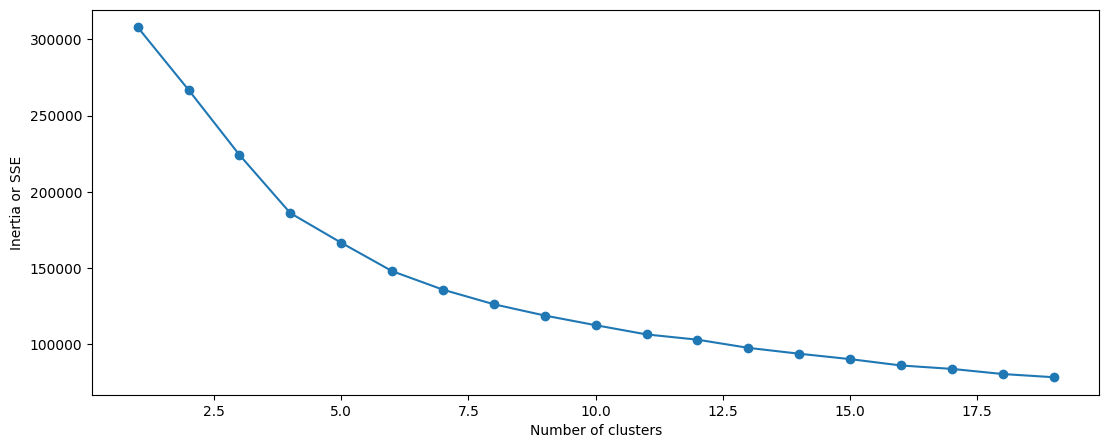

In [45]:
clusters = range(1, 20)
sse=[]
for cluster in clusters:
    model = KMeans(n_clusters=cluster,
               init='k-means++',
               n_init=10,
               max_iter=300,
               tol=0.0001,
               #precompute_distances='auto',
               verbose=0,
               random_state=42,
               copy_x=True)

    model.fit(scaled_df)
    sse.append(model.inertia_)

sse_df = pd.DataFrame(np.column_stack((clusters, sse)), columns=['cluster', 'SSE'])
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(sse_df['cluster'], sse_df['SSE'], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia or SSE')

Se vuelve a ejecutar el modelo con 3 como número de clustes.

In [46]:
model = KMeans(n_clusters=3,
               init='k-means++',
               n_init=10,
               max_iter=300,
               tol=0.0001,
               #precompute_distances='auto',
               verbose=0,
               random_state=42,
               copy_x=True)

model.fit(scaled_df)

KMeans(n_clusters=3, n_init=10, random_state=42)

Se obtiene la precicción del modelo.

In [47]:
pred = model.predict(scaled_df)
pred

array([0, 0, 0, ..., 1, 0, 0])

Se verifica su longitud ya que no puede ser diferente al modelo de pruebas.

In [48]:
len(pred)

38498

Se obtiene la puntuación Silhouette.

In [50]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=3): {silhouette_score(scaled_df, pred)}')

Silhouette Score(n=3): 0.15878796450047888


Se genera el archivo con los resultados para enviar.

In [49]:
dfpred = pd.DataFrame({'pred': pred})
dfpred.to_csv('../Datasets/naguieta.csv', index=False)